In [109]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import csv
import copy
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os,json
import datetime

In [157]:
# Experiment settings

dataset_label = 'synthetic_log_bc1c2'
performance_measure_type = 'F1'
dataset_loc = './DATA/logs/'+ dataset_label +'.csv'
try:
    os.makedirs('./result/%s'%(dataset_label))
except:
    pass

# Set streaming classifier
classifier = 'hatc'
if classifier == 'htc':
    streaming_classifier = tree.HoeffdingTreeClassifier(grace_period=100,split_criterion='info_gain')
elif classifier =='hatc':
    streaming_classifier = tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,split_criterion='info_gain')
elif classifier == 'efdt':
    streaming_classifier = tree.ExtremelyFastDecisionTreeClassifier(grace_period=100,split_criterion='info_gain')

In [158]:
# Invoke parameters for dataset
window_size = 50

with open('./dataset_parameters.json','r') as json_file:
    parameters = json.load(json_file)[dataset_label]
    print(parameters)
    key_pair = parameters['key_pair']
    catatars = parameters['categorical_attrs']
    maximum_prefix = parameters['maximum_prefix']


{'key_pair': {'Case ID': 'caseid', 'Activity': 'activity', 'Complete Timestamp': 'ts'}, 'categorical_attrs': ['activity'], 'maximum_prefix': 12}


In [159]:
dataset = stream.iter_csv(
            dataset_loc
            )

totallength = len(list(dataset))

In [160]:
dataset = stream.iter_csv(
            dataset_loc,
            # drop=['Complete Timestamp'],
            target='outcome'
            )
enctype = 'Index-base'

In [161]:
streaming_db ={}
training_models ={}
feature_matrix ={}

casecount = 0
rowcounter = 0
finished_db ={}
acc_dict ={}
window_acc_dict={'Time':[]}
running_case = 0
prediction_result = {}
graceperiod_finish=0
finished_caseid = set()
usedingrace = set()
window_size = 50
window_label_dist ={}

In [162]:
def performance_measurement(metrics, type='acc'):
    if type == 'acc':
        return_value = metrics.Accuracy()
    elif type =='F1':
        return_value = metrics.F1()
    elif type =='ROCAUC':
        return_value = metrics.ROCAUC()
        
    return return_value

In [163]:
'''
Before test and training streaming event predictive monitoring, grace period is preceded to initialize model by prefix length
and obtain feature matrix to transform future events
'''

for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
    # if dataset_label =='bpic17':
    x['ts'] = x['ts'][:-4]

        # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)
    case_bin.set_enctype(enctype)

    if caseid not in list(streaming_db.keys()):
        case_bin.set_prefix_length(1)    
        streaming_db[caseid] = []
    elif caseid in finished_caseid:
        pass
    else:
        case_bin.set_prefix_length(len(streaming_db[caseid])+1)
        case_bin.set_prev_enc(streaming_db[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded(catattrs=catatars,enctype=enctype)
    ts = case_bin.event['ts']
    streaming_db[caseid].append(case_bin)
    usedingrace.add(caseid)
    # Detect label appeared case 
    if outcome != '' and caseid not in finished_caseid:
        finished_caseid.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(streaming_db[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [streaming_classifier,
                                                               performance_measurement(metrics, type=performance_measure_type),
                                                               utils.window_evaluation(window_size),
                                                               0,0]
                feature_list = list(streaming_db[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            graceperiod_finish = streaming_db[caseid][-1].event['ts']
            for t in training_models.keys():
                training_models[t][4] = graceperiod_finish
            streaming_db.pop(caseid)            
        else:
            break

0.0 % Case finished: 0
3.02 % Case finished: 41
6.03 % Case finished: 86
9.05 % Case finished: 138
12.07 % Case finished: 185


In [164]:
'''
Streaming event label prediction start.
- Test and training steps are executed when case finished/ event arrived with label
'''
streaming_db ={}
for x,y in dataset:
    if rowcounter%3000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
        
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)

    x['ts'] = x['ts'][:-4]

    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
    x.pop('caseid')
    x.pop('outcome')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(streaming_db.keys()):
            case_bin.set_prefix_length(1)    
            streaming_db[caseid] = []
            running_case +=1
        elif caseid in finished_caseid:
            pass
        else:
            case_bin.set_prefix_length(len(streaming_db[caseid])+1)
            case_bin.set_prev_enc(streaming_db[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)
        ts = case_bin.event['ts']
        if case_bin.prefix_length >=2 and case_bin.prefix_length <= maximum_prefix:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
            x_test = case_bin.encoded
            model = training_models['prefix_%s'%(case_bin.prefix_length)][0]
            y_pred = model.predict_one(x_test)
            if type(y_pred) != str:
                y_pred = 'False'
            modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(case_bin.prefix_length)][3]), copy.deepcopy(y_pred)
            case_bin.update_prediction((modelid, (pred_value,ts)))        
        streaming_db[caseid].append(case_bin)

        # Detect label appeared case 
        if outcome != '' and caseid not in finished_caseid:
            finished_caseid.add(caseid)
            # Adding newly finished case to training set.
            casecount +=1    
            # Real training start

            # Modify encoded attributes of cases with feature matrix
            case_length = len(streaming_db[caseid])
            if case_length >maximum_prefix:
                case_length =maximum_prefix
            y = outcome
            for prefix in range(1, case_length):
                streaming_db[caseid][prefix].update_truelabel(y)
                x = streaming_db[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][3] +=1
                last_pred_idx = sorted(streaming_db[caseid][prefix].call_predicted().keys())[-1]
                last_pred = streaming_db[caseid][prefix].call_predicted()[last_pred_idx][0]
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)
                training_models['prefix_%s'%(prefix+1)][2].update(y,last_pred)
                for cases in list(streaming_db.keys()):
                    if len(streaming_db[cases]) >prefix:
                        x_test = streaming_db[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][3]), copy.deepcopy(y_pred)
                        streaming_db[cases][prefix].update_prediction((modelid, (pred_value,ts)))
                        prediction_key = str(cases)+'_'+str(prefix+1)
            
            copying = copy.deepcopy(streaming_db[caseid])
            finished_db[caseid] = copying
            
            streaming_db[caseid] =[]
            running_case -=1
            
            modelupdate_num = {}
#             for t in list(training_models.keys()):
#                 modelupdate_num[t] = training_models[t][3]
#             finished_cases_bin[casecount] =modelupdate_num 
            window_acc_dict['Time'].append(ts)
            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                    
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())
            
            for t in training_models.keys():
                if t not in list(window_acc_dict.keys()):
                    window_acc_dict[t] =[training_models[t][2].get()]
                    
                else:
                    window_acc_dict[t].append(training_models[t][2].get())
                
                    
                # Record label distribution of sliding window
                if t not in list(window_label_dist.keys()):
                    window_label_dist[t] =[training_models[t][2].label_dist()]
                else:
                    window_label_dist[t].append(training_models[t][2].label_dist())

18.1 % Case finished: 273 Running case: 10
36.2 % Case finished: 562 Running case: 6
54.3 % Case finished: 830 Running case: 8
72.4 % Case finished: 1095 Running case: 7
90.5 % Case finished: 1353 Running case: 9


In [165]:
# Continuous evaluation performance by prefix length-case bin average

y_true, target_pred = utils.pl_case_continuous_evaluation(finished_db, type='average')
bin_event_acc_average = {}
max_length = max([len(x) for x in finished_db])
print(max_length)

for prefix in tqdm(list(y_true.keys())):
    t = int(prefix.split('_')[-1])
    if t in range(2,maximum_prefix):
        if '%s'%(t) not in list(bin_event_acc_average.keys()):
            bin_event_acc_average['%s'%(t)] ={'y_true':[],'y_pred':[]}
        else:
            bin_event_acc_average['%s'%(t)]['y_true'].append(y_true[prefix])
            bin_event_acc_average['%s'%(t)]['y_pred'].append(target_pred[prefix])
for prefix in bin_event_acc_average.keys():
    print(accuracy_score(bin_event_acc_average[prefix]['y_true'], bin_event_acc_average[prefix]['y_pred']))
    bin_event_acc_average[prefix]= accuracy_score(bin_event_acc_average[prefix]['y_true'], bin_event_acc_average[prefix]['y_pred'])

8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11196/11196 [00:00<00:00, 486686.71it/s]

0.7414860681114551
0.7345201238390093
0.7267801857585139
0.7229102167182663
0.7275541795665634
0.7352941176470589
0.6444929116684842
0.5669957686882934
0.5754583921015515
0.6237037037037036


In [166]:
# Continuous evaluation performance by prefix length-case bin time decaying

y_true, target_pred = utils.pl_case_continuous_evaluation(finished_db, type='time_decaying')
bin_event_acc_time = {}
max_length = max([len(x) for x in finished_db])
print(max_length)

for prefix in tqdm(list(y_true.keys())):
    t = int(prefix.split('_')[-1])
    if t in range(2,maximum_prefix):
        if '%s'%(t) not in list(bin_event_acc_time.keys()):
            bin_event_acc_time['%s'%(t)] ={'y_true':[],'y_pred':[]}
        else:
            bin_event_acc_time['%s'%(t)]['y_true'].append(y_true[prefix])
            bin_event_acc_time['%s'%(t)]['y_pred'].append(target_pred[prefix])
for prefix in bin_event_acc_time.keys():
    print(accuracy_score(bin_event_acc_time[prefix]['y_true'], bin_event_acc_time[prefix]['y_pred']))
    bin_event_acc_time[prefix]= accuracy_score(bin_event_acc_time[prefix]['y_true'], bin_event_acc_time[prefix]['y_pred'])

8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11196/11196 [00:00<00:00, 486671.58it/s]

0.7360681114551083
0.7314241486068112
0.7221362229102167
0.7260061919504643
0.7329721362229102
0.7414860681114551
0.6553980370774264
0.5796897038081805
0.5937940761636107
0.64

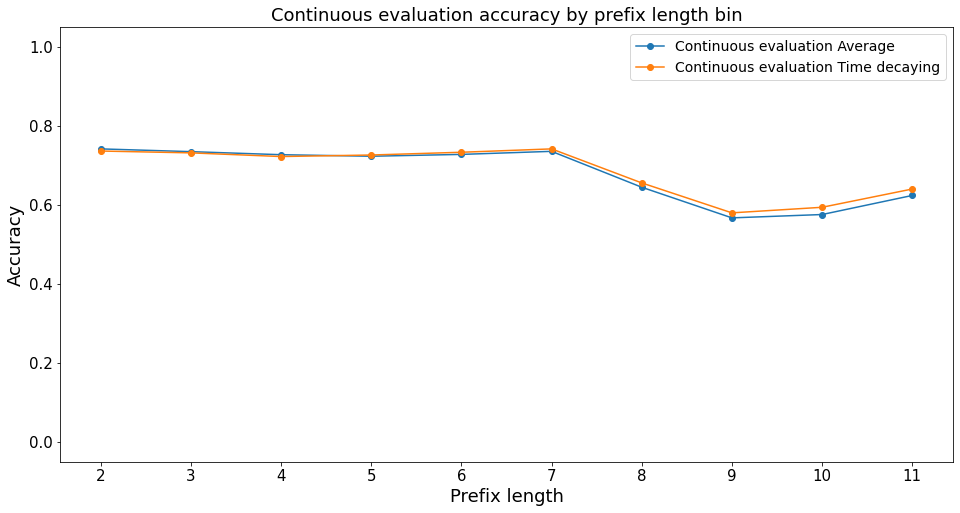

In [167]:
# Continuous evaluation by prefix length
plt.figure(figsize=(16, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
axes.set_ylim([-0.05, 1.05])

x_avg,ce_acc_avg_y = list(bin_event_acc_average.keys()),[bin_event_acc_average[x] for x in bin_event_acc_average.keys()]
x_time,ce_acc_time_y = list(bin_event_acc_time.keys()),[bin_event_acc_time[x] for x in bin_event_acc_time.keys()]
plt.plot(x_avg,ce_acc_avg_y,'-o',label='Continuous evaluation Average')
plt.plot(x_time,ce_acc_time_y,'-o',label='Continuous evaluation Time decaying')

plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')

plt.savefig('./img/%s/%s_continuous_evaluation_plbin.png'%(dataset_label, classifier), dpi=200)
# with open('./result/%s/%s_continuous_evaluation_plbin_average.pkl'%(dataset_label,classifier),'wb') as f:
#     pkl.dump([x_avg,ce_acc_avg_y],f)
    
# with open('./result/%s/%s_continuous_evaluation_plbin_time.pkl'%(dataset_label,classifier),'wb') as f:
#     pkl.dump([x_time,ce_acc_time_y],f)

synthetic_log_bc1c2 hatc window 50 F1.pkl
synthetic_log_bc1c2 hatc window 50 window_F1.pkl


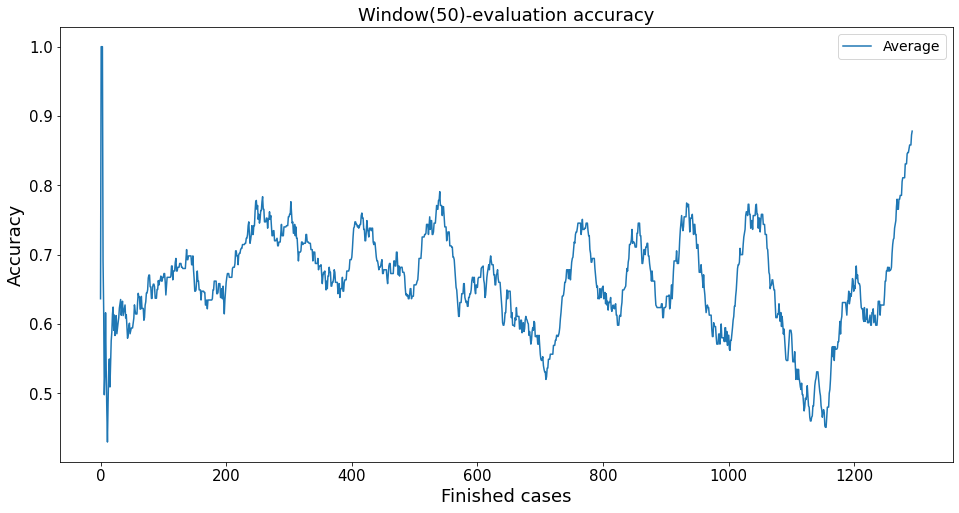

In [168]:
# Real-time window evaluation

plt.figure(figsize=(16, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

average_dict= {'Accuracy':[], 'Time':[]}
for y in range(len(window_acc_dict['prefix_15'])):
    agg_avg = np.mean([window_acc_dict['prefix_%s'%(t)][y] for t in range(2,maximum_prefix+1)])
    average_dict['Accuracy'].append(agg_avg)
plt.plot(average_dict['Accuracy'],label = 'Average')


plt.title('Window(%s)-evaluation accuracy'%(window_size))
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Finished cases')

plt.legend()

name = '%s %s window %s %s.pkl'%(dataset_label,classifier, window_size, performance_measure_type)
print(name)
average_dict['Time'] = window_acc_dict['Time']

with open('./result/%s/%s'%(dataset_label,name) ,'wb') as f:
    pkl.dump(average_dict,f)

name = '%s %s window %s window_%s.pkl'%(dataset_label,classifier, window_size, performance_measure_type)
print(name)

with open('./result/%s/%s'%(dataset_label,name) ,'wb') as f:
    pkl.dump(window_acc_dict,f)
